In [1]:
import os
import sys
import time
import networkx as nx
import scipy.io as sio
import scipy.sparse as sp
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np

# from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# ## for Palatino and other serif fonts use:
# # rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.animation import FuncAnimation

import pickle

%matplotlib inline

import re
numeric_const_pattern = r"""
     [-+]? 
     (?:
         (?: \d* \. \d+ )
         |
         (?: \d+ \.? )
     )
     (?: [Ee] [+-]? \d+ ) ?
     """
rx = re.compile(numeric_const_pattern, re.VERBOSE)

from IPython.display import clear_output
from IPython.display import Video

from scipy.stats.stats import pearsonr

print(sns.__version__)

Matplotlib created a temporary cache directory at /tmp/matplotlib-3xiwos86 because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


0.13.2


/tmp/ipykernel_65406/2191035762.py:42: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
outdir = './output'
csvfile0 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_sgd_nlap_ba_mix_wm1.0_sigmoid_preset1_l2.csv')
csvfile1 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_adam_nlap_ba_mix_wm1.0_sigmoid_preset1_l2.csv')
csvfile2 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_dsgd_nlap_ba_mix_wm1.0_sigmoid_preset1_l2.csv')
csvfile3 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_dadam_nlap_ba_mix_wm1.0_sigmoid_preset1_l2.csv')
csvfile4 = os.path.join(outdir, 'regression_chebnet_loss_trajectory_dams_nlap_ba_mix_wm1.0_sigmoid_preset1_l2.csv')

In [3]:
df0 = pd.read_csv(csvfile0, index_col=0)
df1 = pd.read_csv(csvfile1, index_col=0)
df2 = pd.read_csv(csvfile2, index_col=0)
df3 = pd.read_csv(csvfile3, index_col=0)
df4 = pd.read_csv(csvfile4, index_col=0)

In [4]:
df0 = df0.rename(columns={
    'epoch': 'epoch',
    'mse_train': 'centralized_SGD_train',
    'mse_test': 'centralized_SGD'
})

df1 = df1.rename(columns={
    'epoch': 'epoch',
    'mse_train': 'centralized_Adam_train',
    'mse_test': 'centralized_Adam'
})

df2 = df2.rename(columns={
    'epoch': 'epoch',
    'mse_train': 'D-SGD_train',
    'mse_test': 'D-SGD'
})

df3 = df3.rename(columns={
    'epoch': 'epoch',
    'mse_train': 'D-Adam_train',
    'mse_test': 'D-Adam'
})

df4 = df4.rename(columns={
    'epoch': 'epoch',
    'mse_train': 'D-AMSGrad_train',
    'mse_test': 'D-AMSGrad'
})

In [5]:
df = pd.concat([df0, df1.iloc[:, 1:], df2.iloc[:, 1:], df3.iloc[:, 1:], df4.iloc[:, 1:]], axis=1)

In [6]:
df_train = df[['epoch', 'centralized_SGD_train', 'centralized_Adam_train', 'D-SGD_train', 'D-Adam_train', 'D-AMSGrad_train']]
df_test = df[['epoch', 'centralized_SGD', 'centralized_Adam', 'D-SGD', 'D-Adam', 'D-AMSGrad']]

In [7]:
df_train_melt = df_train.melt(id_vars=['epoch'], value_vars=
                              ['centralized_SGD_train', 'centralized_Adam_train', 
                               'D-SGD_train', 'D-Adam_train', 'D-AMSGrad_train'])
df_test_melt = df_test.melt(id_vars=['epoch'], value_vars=
                            ['centralized_SGD', 'centralized_Adam', 
                             'D-SGD', 'D-Adam', 'D-AMSGrad'])

Text(0, 0.5, 'MSE')

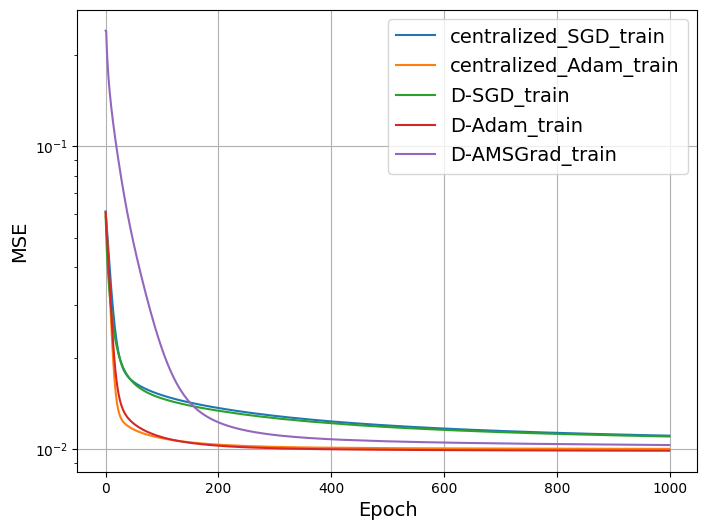

In [8]:
fig, ax = plt.subplots(1,1,sharey=True, figsize=(8, 6))
sns.lineplot(x='epoch', y='value', hue="variable",
             hue_order=['centralized_SGD_train', 'centralized_Adam_train', 'D-SGD_train', 'D-Adam_train', 'D-AMSGrad_train'],
             data=df_train_melt,
             errorbar=None, ax=ax)
ax.set_yscale('log')
ax.grid(True)
ax.legend(title=False, fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)

Text(0, 0.5, 'MSE')

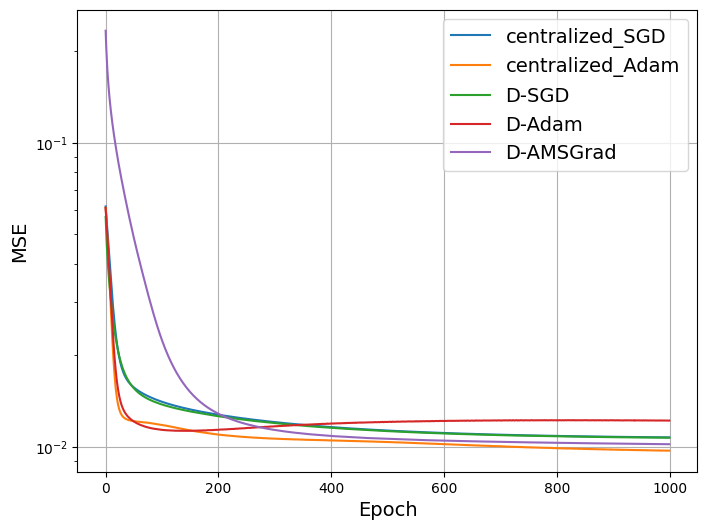

In [9]:
fig, ax = plt.subplots(1,1,sharey=True, figsize=(8, 6))
sns.lineplot(x='epoch', y='value', hue="variable",
             hue_order=['centralized_SGD', 'centralized_Adam', 'D-SGD', 'D-Adam', 'D-AMSGrad'],
             data=df_test_melt,
             errorbar=None, ax=ax)
ax.set_yscale('log')
ax.grid(True)
ax.legend(title=False, fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('MSE', fontsize=14)

In [10]:
# Communication overhead for each MP scheme
batch_size = 100
L = 2
K=1
T_cent = batch_size*L
T_naive = batch_size*(2*L-1+K)
T_naive_pb = batch_size*L+L-1+K
T_do = batch_size*L+L-1

In [11]:
df_sgd = pd.DataFrame({
    'mp': range(len(df_train)*T_cent),
    'variable': 'centralized_SGD',
    'value': df_test_melt[df_train_melt['variable'] == 'centralized_SGD_train'].value.repeat(T_cent)
})
df_adam = pd.DataFrame({
    'mp': range(len(df_train)*T_cent),
    'variable': 'centralized_Adam',
    'value': df_test_melt[df_train_melt['variable'] == 'centralized_Adam_train'].value.repeat(T_cent)
})
df_naive = pd.DataFrame({
    'mp': range(len(df_train)*T_naive),
    'variable': 'D-naive',
    'value': df_test_melt[df_train_melt['variable'] == 'centralized_SGD_train'].value.repeat(T_naive)
})
df_naive_pb = pd.DataFrame({
    'mp': range(len(df_train)*T_naive_pb),
    'variable': 'D-naive-PB',
    'value': df_test_melt[df_train_melt['variable'] == 'centralized_SGD_train'].value.repeat(T_naive_pb)
})
df_dsgd = pd.DataFrame({
    'mp': range(len(df_train)*T_do),
    'variable': 'D-SGD',
    'value': df_test_melt[df_train_melt['variable'] == 'D-SGD_train'].value.repeat(T_do)
})
df_dadam = pd.DataFrame({
    'mp': range(len(df_train)*T_do),
    'variable': 'D-Adam',
    'value': df_test_melt[df_train_melt['variable'] == 'D-Adam_train'].value.repeat(T_do)
})
df_dams = pd.DataFrame({
    'mp': range(len(df_train)*T_do),
    'variable': 'D-AMSGrad',
    'value': df_test_melt[df_train_melt['variable'] == 'D-AMSGrad_train'].value.repeat(T_do)
})

In [12]:
df_mp = pd.concat([df_sgd, df_adam, df_naive, df_naive_pb, df_dsgd, df_dadam, df_dams], axis=0)

Text(0, 0.5, 'MSE')

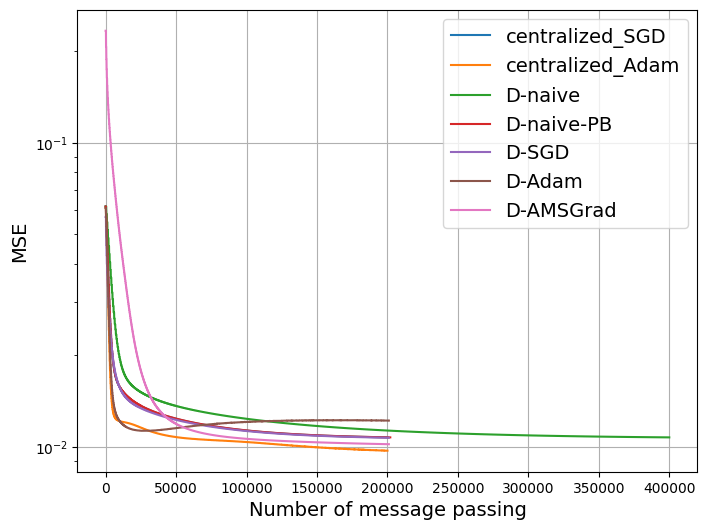

In [13]:
fig, ax = plt.subplots(1,1,sharey=True, figsize=(8, 6))
sns.lineplot(x='mp', y='value', hue="variable",
             hue_order=['centralized_SGD', 'centralized_Adam', 'D-naive', 'D-naive-PB', 'D-SGD', 'D-Adam', 'D-AMSGrad'],
             data=df_mp,
             errorbar=None, ax=ax)
ax.set_yscale('log')
ax.grid(True)
ax.legend(title=False, fontsize=14)
plt.xlabel('Number of message passing', fontsize=14)
plt.ylabel('MSE', fontsize=14)
# plt.xlim([199000, 201000])